In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# 1. Generate Synthetic Monthly Sales Data (3 Years: 2021 - 2023)
np.random.seed(42)
dates = pd.date_range(start='2021-01-01', end='2023-12-01', freq='MS')

# Create a base trend + yearly seasonality (sine wave) + random noise
trend = np.linspace(10000, 25000, len(dates))
seasonality = 5000 * np.sin(np.linspace(0, 3 * 2 * np.pi, len(dates)))
noise = np.random.normal(0, 1500, len(dates))

sales = trend + seasonality + noise

df = pd.DataFrame({'Date': dates, 'Sales': sales})
df.set_index('Date', inplace=True) # Time series needs Date as the index

print("Time Series Data Generated. Shape:", df.shape)
df.head()

Time Series Data Generated. Shape: (36, 1)


,Sales
Date,
2021-01-01,10745.071230
2021-02-01,12785.671364
2021-03-01,16231.653324
2021-04-01,18565.224403
2021-05-01,15535.921921


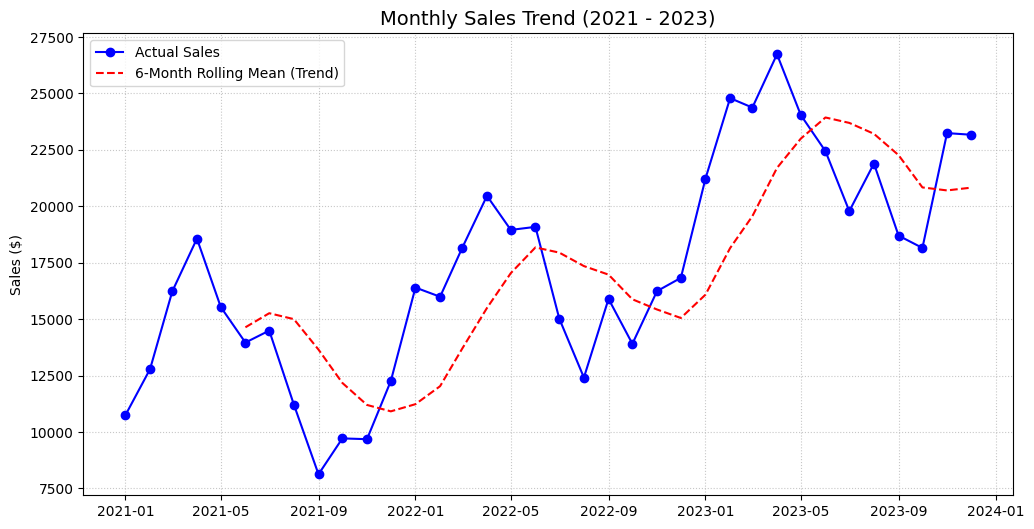

In [2]:
# Calculate a 6-month rolling mean to smooth out the noise
df['Rolling_Mean'] = df['Sales'].rolling(window=6).mean()

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Sales'], label='Actual Sales', marker='o', color='blue')
plt.plot(df.index, df['Rolling_Mean'], label='6-Month Rolling Mean (Trend)', color='red', linestyle='--')

plt.title('Monthly Sales Trend (2021 - 2023)', fontsize=14)
plt.ylabel('Sales ($)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

In [3]:
# 1. Split Data by Time
train = df.iloc[:-12]['Sales'] # First 24 months
test = df.iloc[-12:]['Sales']  # Last 12 months (2023)

# 2. Fit Holt-Winters Exponential Smoothing Model
# (This model is great because it captures both Trend and Seasonality)
model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)
fitted_model = model.fit()

# 3. Forecast the next 12 months
forecast = fitted_model.forecast(steps=12)

# Save forecast into a dataframe for export later
forecast_df = pd.DataFrame({'Date': test.index, 'Actual_Sales': test.values, 'Forecasted_Sales': forecast.values})
forecast_df.set_index('Date', inplace=True)

print("Model Trained and Forecast Generated!")

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Model Trained and Forecast Generated!


Mean Absolute Error (MAE): $2048.79
Mean Absolute Percentage Error (MAPE): 8.96%


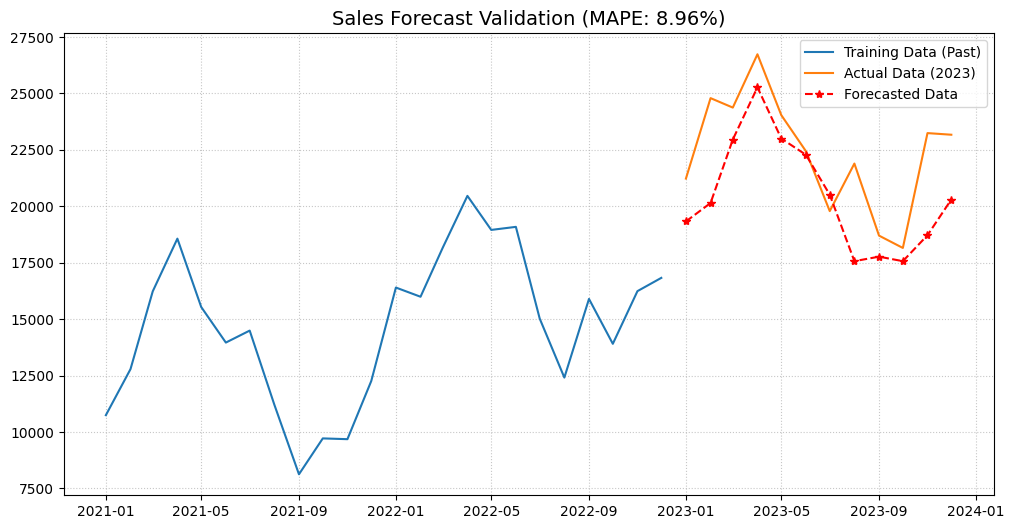

Forecast exported to 'forecast_output.csv'


In [4]:
# 1. Calculate Error Metrics
mae = mean_absolute_error(forecast_df['Actual_Sales'], forecast_df['Forecasted_Sales'])
mape = mean_absolute_percentage_error(forecast_df['Actual_Sales'], forecast_df['Forecasted_Sales']) * 100

print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# 2. Plot Train vs Test vs Forecast
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values, label='Training Data (Past)')
plt.plot(test.index, test.values, label='Actual Data (2023)')
plt.plot(forecast.index, forecast.values, label='Forecasted Data', color='red', linestyle='dashed', marker='*')

plt.title(f'Sales Forecast Validation (MAPE: {mape:.2f}%)', fontsize=14)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

# 3. Export Output
forecast_df.to_csv('forecast_output.csv')
print("Forecast exported to 'forecast_output.csv'")